In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [61]:
path = 'card_data.csv'
x = pd.read_csv(path, encoding='latin', error_bad_lines=False)
df = pd.DataFrame(x)
df.head()

,Name,Type,Level,Race,Attribute,ATK,DEF
0,Limit Reverse,Trap Card,NaN,Continuous,NaN,NaN,NaN
1,The 13th Grave,Normal Monster,3.0,Zombie,DARK,1200.0,900.0
2,Gem-Enhancement,Trap Card,NaN,Normal,NaN,NaN,NaN
3,Magician's Circle,Trap Card,NaN,Normal,NaN,NaN,NaN
4,Castle of Dark Illusions,Flip Effect Monster,4.0,Fiend,DARK,920.0,1930.0


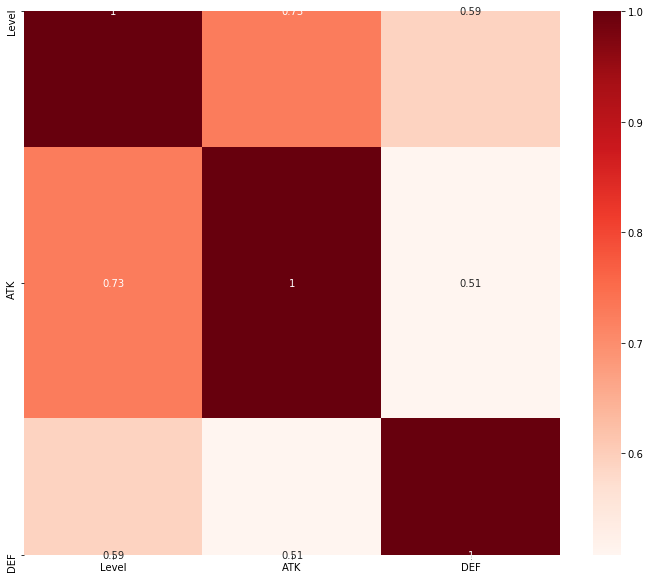

In [59]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [67]:
cor_target = abs(cor["Level"])
relevant_features = cor_target[cor_target>0.5]
relevant_features

Level    1.000000
ATK      0.725354
DEF      0.592225
Name: Level, dtype: float64

In [68]:
print(df[["Level","ATK"]].corr())
print(df[["Level","DEF"]].corr())

          Level       ATK
Level  1.000000  0.725354
ATK    0.725354  1.000000
          Level       DEF
Level  1.000000  0.592225
DEF    0.592225  1.000000


In [104]:
df_dropped = df.dropna(subset=['ATK'])
X=df_dropped.drop("Name",1)
X=X.drop("Type",1)
X=X.drop("Race",1)
X=X.drop("Attribute",1)
y=X["ATK"]
X_1 = sm.add_constant(X)
model = sm.OLS(y,X_1).fit()
model.pvalues.sort_values(ascending=False)


const     8.466442e-04
DEF       1.797386e-11
Level    4.166983e-116
ATK       0.000000e+00
dtype: float64

In [105]:
#Backward Elimination
cols = list(X.columns)
pmax = 1

while (len(cols)>0):
    p = []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
        
selected_features_BE = cols
print(selected_features_BE)

['Level', 'ATK', 'DEF']


In [106]:
model = LinearRegression()

#Método RFE
rfe = RFE(model, 7, verbose=1)

#Transformando los datos usando el método RFE
X_rfe = rfe.fit_transform(X,y)  

#Encontrando el modelo de los datos
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True]
[1 1 1]


In [107]:
#Número de características
nof_list = np.arange(1,13)            
high_score = 0

#Proceso para almacenar las características óptimas
nof = 0           
score_list = []

for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
        
print("Número óptimo de características: %d" %nof)
print("Desempeño con %d características: %f" % (nof, high_score))

Número óptimo de características: 1
Desempeño con 1 características: 1.000000


In [110]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index=cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['Level', 'ATK', 'DEF'], dtype='object')


In [111]:
reg = LassoCV()
reg.fit(X, y)
coef = pd.Series(reg.coef_, index = X.columns)
print("Número óptimo de características:" + str(sum(coef != 0)))
print("Desempeño mediante la regularización Lasso: %f" %reg.score(X,y))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Número óptimo de características:1
Desempeño mediante la regularización Lasso: 0.999999


Text(0.5, 1.0, 'Importancia de las características usando el modelo de Lasso')

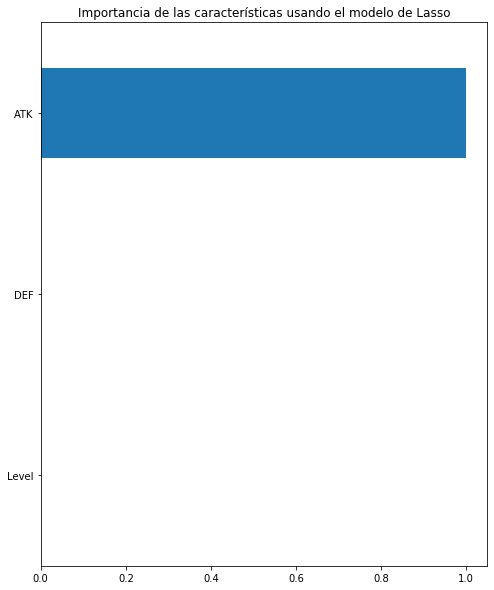

In [112]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Importancia de las características usando el modelo de Lasso")